In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
!pip install tensorflow
!pip install bertopic
!pip install flair
!pip install pyldavis
!pip install contractions
!pip install happytransformer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 3.10.1
    Uninstalling importlib-metadata-3.10.1:
      Successfully uninstalled importlib-metadata-3.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
konoha 4.6.5 requires importlib-metadata<4.0.0,>=3.7.0, but you have importlib-metadata 6.0.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached importlib_metadata-3.10.1-py3-none-any.whl (14 kB)
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 6.0.0
    Uninstalling importlib-metadata-6.0.0

In [28]:
import os
import pandas as pd
import numpy as np
import re
import sys
import matplotlib.pyplot as plt
import seaborn as sns

import tempfile
import logging
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from nltk.tokenize.toktok import ToktokTokenizer

from string import punctuation


from flair.models import TextClassifier
from flair.data import Sentence

# Topic Modeling
from gensim import corpora, models
from collections import OrderedDict
import pyLDAvis.gensim_models



# Transformers
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelWithLMHead

# Word Cloud
from wordcloud import WordCloud
from string import punctuation


import unicodedata
import contractions
import spacy
from bs4 import BeautifulSoup



from collections import Counter

from happytransformer import HappyTextToText
from happytransformer import TTSettings

import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

# Variables Definations

In [29]:
tokenizer=RegexpTokenizer(r'\w+')
ps=PorterStemmer()

nltk.download('stopwords')
en_stop=set(stopwords.words('english'))
nltk.download('vader_lexicon')



tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
custom_stopwords = ['xx', 'xxxx', 'xxxa', 'xxxxxxxx', '&#9;', 'xxxxxxx', 'yyyyyyyy', "t", "co", "https", "amp", "U", "first", "second", "w", "via", "today", "one", "go", "said","ji","featured" ]
stopword_list.extend(custom_stopwords)


wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

happy_tt = HappyTextToText("T5", "prithivida/grammar_error_correcter_v1")
settings = TTSettings(do_sample=True, top_k=10, temperature=0.5,  min_length=1, max_length=100)


TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Folder "/tmp" will be used to save temporary dictionary and corpus.


# Loading Data and Its information

In [ ]:
vaccination_all_tweets = pd.read_csv('/content/drive/MyDrive/COVID_19_Sentiment_Paper/dataset/vaccination_all_tweets.csv', error_bad_lines=False);

In [ ]:
vaccination_all_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228207 entries, 0 to 228206
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                228207 non-null  int64 
 1   user_name         228205 non-null  object
 2   user_location     161296 non-null  object
 3   user_description  211189 non-null  object
 4   user_created      228207 non-null  object
 5   user_followers    228207 non-null  int64 
 6   user_friends      228207 non-null  int64 
 7   user_favourites   228207 non-null  int64 
 8   user_verified     228207 non-null  bool  
 9   date              228207 non-null  object
 10  text              228207 non-null  object
 11  hashtags          178504 non-null  object
 12  source            228088 non-null  object
 13  retweets          228207 non-null  int64 
 14  favorites         228207 non-null  int64 
 15  is_retweet        228207 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory

In [ ]:
vaccination_all_tweets.describe()

,id,user_followers,user_friends,user_favourites,retweets,favorites
count,2.282070e+05,2.282070e+05,228207.000000,2.282070e+05,228207.000000,228207.000000
mean,1.407541e+18,9.605393e+04,986.736204,1.210417e+04,2.489284,10.819020
std,2.908485e+16,8.389053e+05,5293.500468,3.908233e+04,51.079821,199.527693
min,1.337728e+18,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,1.381940e+18,5.500000e+01,27.000000,5.700000e+01,0.000000,0.000000
50%,1.408133e+18,3.280000e+02,229.000000,9.960000e+02,0.000000,0.000000
75%,1.428688e+18,1.521000e+03,794.000000,7.300000e+03,1.000000,2.000000
max,1.463251e+18,1.635305e+07,582461.000000,1.299600e+06,12294.000000,54017.000000


# Proprocessing Tweets - Cleaning

In [ ]:
def normalize_tweets(corpus,english_correction= True, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, special_char_removal=True,
                     stopword_removal=True, remove_digits=True):
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # English Correction
        if english_correction:
            doc= english_correction(doc)
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ', doc)
    
        # remove special characters and\or digits
        if special_char_removal:
            # insert spaces between special characters to isolate them
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)
            # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)

        normalized_corpus.append(doc)

    return normalized_corpus

def english_correction(text):
    result = happy_tt.generate_text(text, args=settings)
    return result.text

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text


def expand_contractions(text):
    return contractions.fix(text)


def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text



def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text


def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text


In [ ]:
vaccination_all_tweets['text'] = normalize_tweets(vaccination_all_tweets['text'])

In [ ]:
vaccination_all_tweets['text'].head()

0         folks daikon paste could treat cytokine storm ...
1         world wrong side history year hopefully bigges...
2         coronavirus sputnikv astrazeneca pfizerbiontec...
3         facts immutable senator even ethically sturdy ...
4         explain need vaccine borisjohnson matthancock ...
                                ...                        
228202    urban bengaluru covidvaccine availability pm f...
228203    bbmp bengaluru covidvaccine availability pm fr...
228204    urban bengaluru covidvaccine availability pm f...
228205    promote vaccines leaving stronger russia vacci...
228206    urban bengaluru covidvaccine availability pm f...
Name: text, Length: 228207, dtype: object

#  Sentiment Analysis Tweets Classification

In [ ]:
sia = SentimentIntensityAnalyzer()
flairSentimentClassifier = TextClassifier.load('en-sentiment')
transformerSentimentClassiferBertTweet = pipeline("sentiment-analysis", model="justinqbui/bertweet-covid-vaccine-tweets-finetuned")
transformerSentimentClassiferTwitterRoberta = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")


def majority_voting(text):
    m1, m2, m3, m4 = "neutral", "neutral", "neutral", "neutral"
    if text:
        # polarity by text blob
        polarity = TextBlob(text).sentiment.polarity
        m1 = "positive" if polarity > 0 else "negative" if polarity < 0 else "neutral"

        # polarity by Vader
        scores = sia.polarity_scores(text)
        m2 = "positive" if scores["compound"] > 0 else "negative" if scores["compound"] < 0 else "neutral"

        # polarity by Flair
        sentence = Sentence(text)
        flairSentimentClassifier.predict(sentence)
        m3 = sentence.labels[0].to_dict()['value'].lower()

        # polarity by transformer
        sentiment = transformerSentimentClassiferBertTweet(text)
        m4 = sentiment[0]["label"].lower()

        sentiment = transformerSentimentClassiferTwitterRoberta(text)
        m5 = sentiment[0]["label"].lower()


    clf_list = [m1, m2, m3, m4, m5]
    return Counter(clf_list).most_common(1)[0][0]

2023-02-28 13:12:20,349 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


In [ ]:
vaccination_all_tweets['sentiment'] = vaccination_all_tweets['text'].apply(majority_voting)

In [ ]:
vaccination_all_tweets.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,sentiment
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,folks daikon paste could treat cytokine storm ...,['PfizerBioNTech'],Twitter for Android,0,0,False,neutral
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,world wrong side history year hopefully bigges...,NaN,Twitter Web App,1,1,False,negative
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,coronavirus sputnikv astrazeneca pfizerbiontec...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,neutral
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,facts immutable senator even ethically sturdy ...,NaN,Twitter Web App,446,2129,False,positive
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,explain need vaccine borisjohnson matthancock ...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,neutral


# Tweets emotions labeling

In [ ]:
from transformers import pipeline
from tqdm.notebook import tqdm
tqdm.pandas()

def emotion_classifer(text):
    emo_classifier = pipeline("text-classification",model='bhadresh-savani/roberta-base-emotion', return_all_scores=True)
    emotions = emo_classifier(text)
    return  emotions[0][0]['label']

In [ ]:
vaccination_all_tweets["emotions"]= vaccination_all_tweets['text'][0:10].progress_apply(emotion_classifer)

  0%|          | 0/10 [00:00<?, ?it/s]

## Tweet classification using Zero-shot classifier as anti-pro vaccination and Topic classification

In [ ]:
classifier = pipeline("zero-shot-classification",model="ans/vaccinating-covid-tweets")

In [ ]:
# Zeroshot labler 
def zero_shot_label(text, candidate_labels):
    class_pre= classifier(text, candidate_labels)
    return  class_pre['labels'][0]

In [ ]:
candidate_labels_pro_anti = ['pro-vaccines', 'anti-vaccine' ]
vaccination_all_tweets["tweet_topics"]= vaccination_all_tweets['text'][0:10].progress_apply(zero_shot_label,candidate_labels= candidate_labels_pro_anti)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
candidate_labels_topic_classification = ['Opinions and emotions around vaccines and vaccination', ' Knowledge about vaccines', 'Vaccines as a global issue', 'Vaccine administration ', 'Progress on vaccine development and authorization proposed' ]
vaccination_all_tweets["tweet_classification"]= vaccination_all_tweets['text'][0:10].progress_apply(zero_shot_label,candidate_labels= candidate_labels_topic_classification)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
vaccination_all_tweets.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,sentiment,emotions,tweet_topics,tweet_classification
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,folks daikon paste could treat cytokine storm ...,['PfizerBioNTech'],Twitter for Android,0,0,False,neutral,sadness,pro-vaccines,Vaccines as a global issue
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,world wrong side history year hopefully bigges...,NaN,Twitter Web App,1,1,False,negative,sadness,pro-vaccines,Progress on vaccine development and authorizat...
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,coronavirus sputnikv astrazeneca pfizerbiontec...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,neutral,sadness,pro-vaccines,Progress on vaccine development and authorizat...
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,facts immutable senator even ethically sturdy ...,NaN,Twitter Web App,446,2129,False,positive,sadness,pro-vaccines,Progress on vaccine development and authorizat...
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,explain need vaccine borisjohnson matthancock ...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,neutral,sadness,pro-vaccines,Progress on vaccine development and authorizat...


In [ ]:
vaccination_all_tweets.to_csv("/content/drive/MyDrive/COVID_19_Sentiment_Paper/dataset/vaccination_all_classified_tweets.csv")

# Data Analysis 

## Retrieve the categorized preprocessed data.

In [32]:
vax_tweets = pd.read_csv('/content/drive/MyDrive/COVID_19_Sentiment_Paper/dataset/vaccination_all_classified_tweets.csv',parse_dates=['date']);

In [33]:
vax_tweets['text'] = normalize_tweets(vax_tweets['text'])

In [34]:
today = pd.Timestamp.today().date()
vax_tweets = vax_tweets[vax_tweets['date']!=today]

# Data Exploration

In [ ]:
def getMissingData(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [ ]:
getMissingData(vax_tweets)

,Unnamed: 0,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,...,textfortopic,hashtags_count,hashtags_individual,subjectivity,polarity_textblob,polarity_vader,polarity_roberta,polarity_T5,sentiment,emotions
Total,0,0,1,49541,10541,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0.0,0.0,0.000656,32.503805,6.915941,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Types,int64,float64,object,object,object,float64,int64,int64,int64,bool,...,object,int64,object,float64,object,object,object,object,object,object


In [ ]:
def getMostFrequentValues(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    items = []
    vals = []
    for col in data.columns:
        itm = data[col].value_counts().index[0]
        val = data[col].value_counts().values[0]
        items.append(itm)
        vals.append(val)
    tt['Most frequent item'] = items
    tt['Frequence'] = vals
    tt['Percent from total'] = np.round(vals / total * 100, 3)
    return(np.transpose(tt))

In [ ]:
getMostFrequentValues(vax_tweets)

,Unnamed: 0,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,...,textfortopic,hashtags_count,hashtags_individual,subjectivity,polarity_textblob,polarity_vader,polarity_roberta,polarity_T5,sentiment,emotions
Total,152416,152416,152415,102875,141875,152416,152416,152416,152416,152416,...,152416,152416,152416,152416,152416,152416,152416,152416,152416,152416
Most frequent item,0,1380000000000000000.0,CowinBangalore,India,Follow us to get update as soon as 18 plus vac...,44333.78941,1102,0,1,False,...,Got my second dose of the #Moderna #vaccine to...,1,"[""['None']""]",0.0,neutral,neutral,positive,positive,positive,joy
Frequence,1,30934,11495,5781,11418,11678,2032,13028,7053,138597,...,16,72439,28532,72607,83174,75795,98832,88942,65889,89724
Percent from total,0.001,20.296,7.542,5.619,8.048,7.662,1.333,8.548,4.627,90.933,...,0.01,47.527,18.72,47.637,54.57,49.729,64.844,58.355,43.23,58.868


## Visualize the data distribution

In [ ]:
def getPlotCount(feature, title, df, size=1, ordered=True):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    if ordered:
        g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='Set3')
    else:
        g = sns.countplot(df[feature], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()    

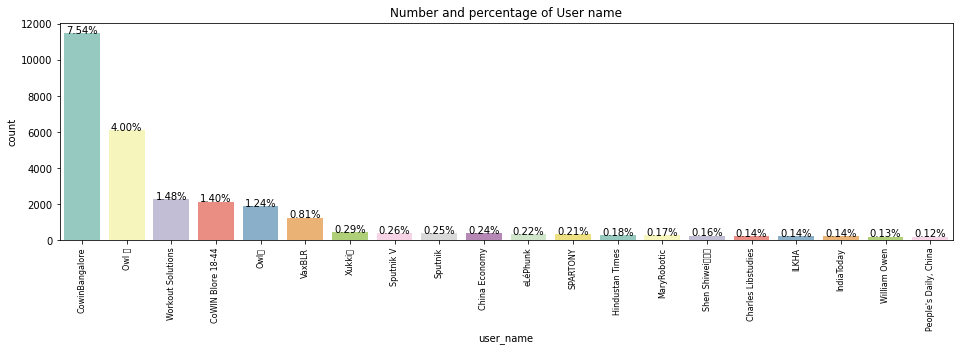

In [ ]:
getPlotCount("user_name", "User name", vax_tweets ,4)

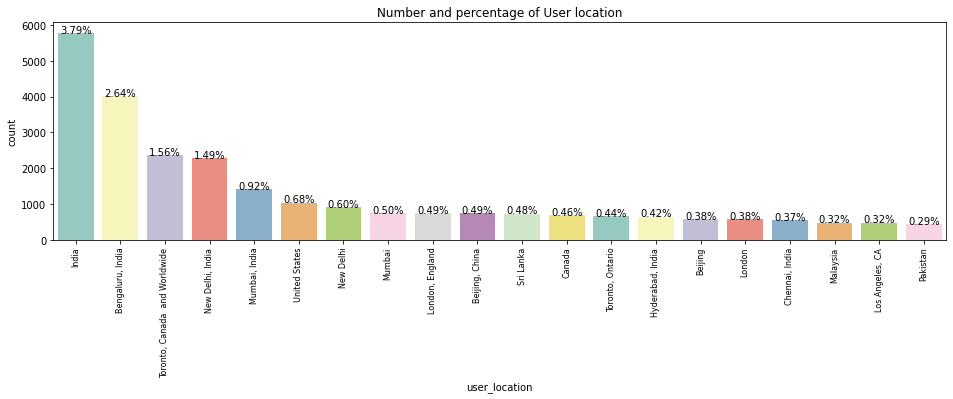

In [ ]:
getPlotCount("user_location", "User location", vax_tweets,4)

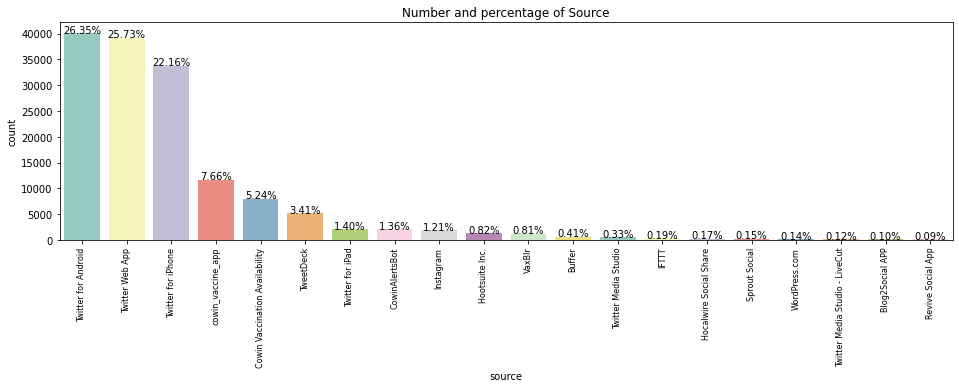

In [ ]:
getPlotCount("source", "Source", vax_tweets,4)

# Word Clouds

In [35]:
from wordcloud import WordCloud, STOPWORDS
def getWordcloud(data, title=""):
    text = " ".join(t for t in data.dropna())
    stopwords = set(STOPWORDS)
    stopwords.update(["t", "co", "https", "amp", "U", "first", "second", "w", "via", "today", "one", "go", "said", "sec", "yet", "please", "open","got", "given", "well"])
    wordcloud = WordCloud(stopwords=stopwords, scale=4, max_font_size=50, max_words=500,background_color="black").generate(text)
    fig = plt.figure(1, figsize=(16,16))
    plt.axis('off')
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

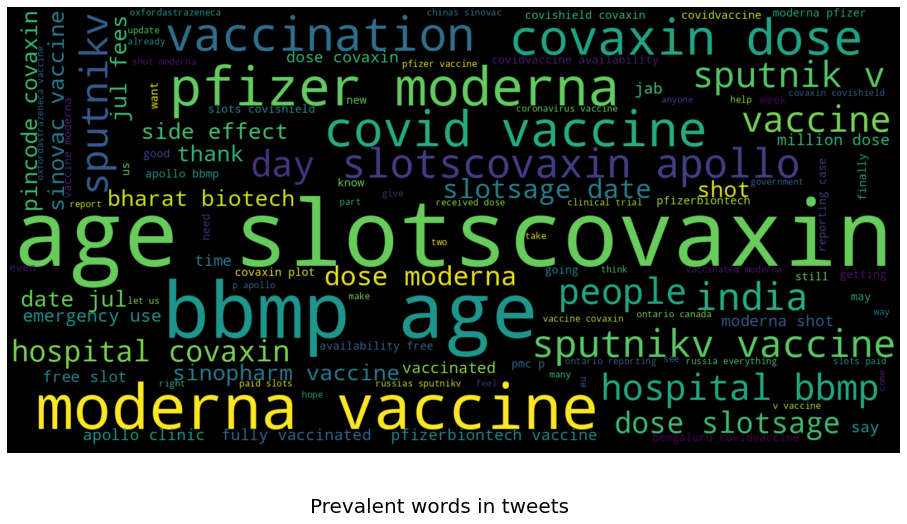

In [36]:
getWordcloud(vax_tweets['text'], title = 'Prevalent words in tweets')

# Hashtags analysis

In [ ]:
def plotFeaturesDistribution(features, title, df, isLog=False):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        if(isLog):
            sns.distplot(np.log1p(df[feature]),kde=True,hist=False, bins=120, label=feature)
        else:
            sns.distplot(df[feature],kde=True,hist=False, bins=120, label=feature)
    plt.xlabel('')
    plt.legend()
    plt.show()


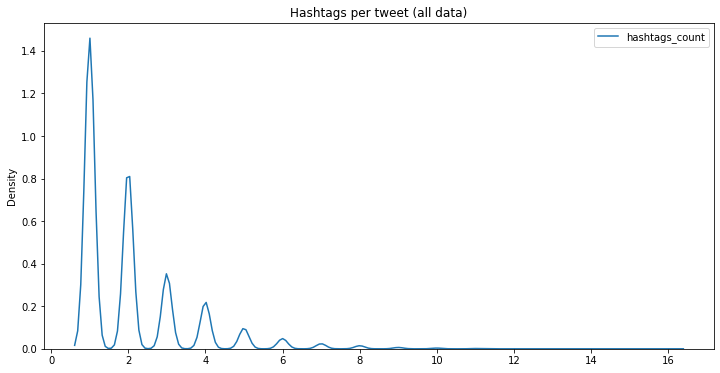

In [ ]:
vax_tweets['hashtags'] = vax_tweets['hashtags'].replace(np.nan, "['None']", regex=True)
vax_tweets['hashtags'] = vax_tweets['hashtags'].apply(lambda x: x.replace('\\N',''))
vax_tweets['hashtags_count'] = vax_tweets['hashtags'].apply(lambda x: len(x.split(',')))
plotFeaturesDistribution(['hashtags_count'], 'Hashtags per tweet (all data)', vax_tweets)

In [ ]:
vax_tweets['hashtags_individual'] = vax_tweets['hashtags'].apply(lambda x: x.split(','))
from itertools import chain
all_hashtags = set(chain.from_iterable(list(vax_tweets['hashtags_individual'])))
print(f"There are totally: {len(all_hashtags)}")

There are totally: 32086


In [ ]:
vax_tweets['hashtags_individual'].head()

0                                 [['PfizerBioNTech']]
1                                           [['None']]
2    [['coronavirus',  'SputnikV',  'AstraZeneca', ...
3                                           [['None']]
4    [['whereareallthesickpeople',  'PfizerBioNTech']]
Name: hashtags_individual, dtype: object

## Extract country from location

We load the country list from the additional database we added to this Notebook. We also create a `country` column in the original dataset.

In [ ]:
country_df = pd.read_csv("/content/drive/MyDrive/COVID_19_Sentiment_Paper/dataset/wikipedia-iso-country-codes.csv")

In [ ]:
country_df.columns = ["country", "alpha2", "alpha3", "numeric", "iso"]
country_df.head()

,country,alpha2,alpha3,numeric,iso
0,Zimbabwe,ZW,ZWE,716,ISO 3166-2:ZW
1,Zambia,ZM,ZMB,894,ISO 3166-2:ZM
2,Yemen,YE,YEM,887,ISO 3166-2:YE
3,Western Sahara,EH,ESH,732,ISO 3166-2:EH
4,Wallis and Futuna,WF,WLF,876,ISO 3166-2:WF


In [ ]:
vax_tweets['country'] = vax_tweets['user_location']

In [ ]:
dataCountryWise = vax_tweets.merge(country_df, on="country")

In [ ]:
dataCountryWise.head()

,Unnamed: 0,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,...,polarity_vader,polarity_roberta,polarity_T5,sentiment,emotions,country,alpha2,alpha3,numeric,iso
0,12,1.340000e+18,WION,India,#WION: World Is One | Welcome to India’s first...,42450.15618,292510,91,7531,True,...,positive,positive,positive,positive,anger,India,IN,IND,356,ISO 3166-2:IN
1,75,1.340000e+18,Prof. Manish Thakur,India,#Proprietor English Academy #Blockchain #AI #I...,41071.57645,3372,1713,119631,False,...,neutral,positive,positive,neutral,joy,India,IN,IND,356,ISO 3166-2:IN
2,94,1.340000e+18,India Blooms,India,A news and reference portal on India and a 24X...,40096.47192,16816,2448,20,False,...,neutral,positive,positive,neutral,anger,India,IN,IND,356,ISO 3166-2:IN
3,131,1.340000e+18,Rachna Tandon,India,"District Epidemiologist, Meerut (IDSP). MDI-Gu...",41914.83839,72,120,66,False,...,positive,positive,positive,positive,joy,India,IN,IND,356,ISO 3166-2:IN
4,159,1.340000e+18,India.com,India,Follow https://t.co/RBTHZHv1ga for breaking ne...,39876.68064,13417,399,349,True,...,neutral,negative,negative,negative,joy,India,IN,IND,356,ISO 3166-2:IN


In [ ]:
tw_add_df = dataCountryWise.groupby(["country", "iso", "alpha3"])['text'].count().reset_index()
tw_add_df.columns = ["country", "iso", "alpha3", "tweets"]

In [ ]:
import plotly.express as px

def plotMap(dd_df, title):
    hover_text = []
    for index, row in dd_df.iterrows():
        hover_text.append((f"country: {row['country']}<br>tweets: {row['tweets']}\
                          <br>country code: {row['iso']}<br>country alpha3: {row['alpha3']}"))
    dd_df['hover_text'] = hover_text

    fig = px.choropleth(dd_df, 
                        locations="alpha3",
                        hover_name='hover_text',
                        color="tweets",
                        projection="natural earth",
                        color_continuous_scale=px.colors.sequential.Plasma,
                        width=900, height=700)
    fig.update_geos(   
        showcoastlines=True, coastlinecolor="DarkBlue",
        showland=True, landcolor="LightGrey",
        showocean=True, oceancolor="LightBlue",
        showlakes=True, lakecolor="Blue",
        showrivers=True, rivercolor="Blue",
        showcountries=True, countrycolor="DarkBlue"
    )
    fig.update_layout(title = title, geo_scope="world")
    fig.show()    

In [ ]:
print(f"tweets containing country information: {tw_add_df.tweets.sum()}")
print(f"tweets containing country information; distinct countries: {tw_add_df.country.shape[0]}")

tweets containing country information: 13278
tweets containing country information; distinct countries: 155


In [ ]:
plotMap(tw_add_df, "Tweets per country (where country is specified)")

# Hastag Analysis

In [ ]:
vax_tweets['hashtags']= vax_tweets['hashtags'].replace(np.nan,'nonehastag',regex = True)

In [ ]:
vax_tweets['hashtags']= vax_tweets['hashtags'].apply(lambda x: x.split(',')) 

In [ ]:
neutral_tweets=  vax_tweets.loc[vax_tweets['sentiment'] == 'neutral']
negative_tweets=  vax_tweets.loc[vax_tweets['sentiment'] == 'negative']
postive_tweets=  vax_tweets.loc[vax_tweets['sentiment'] == 'positive']
HT_neutral= neutral_tweets['hashtags'].explode()
HT_negative= negative_tweets['hashtags'].explode()
HT_positive= postive_tweets['hashtags'].explode()

#### Negative tweets

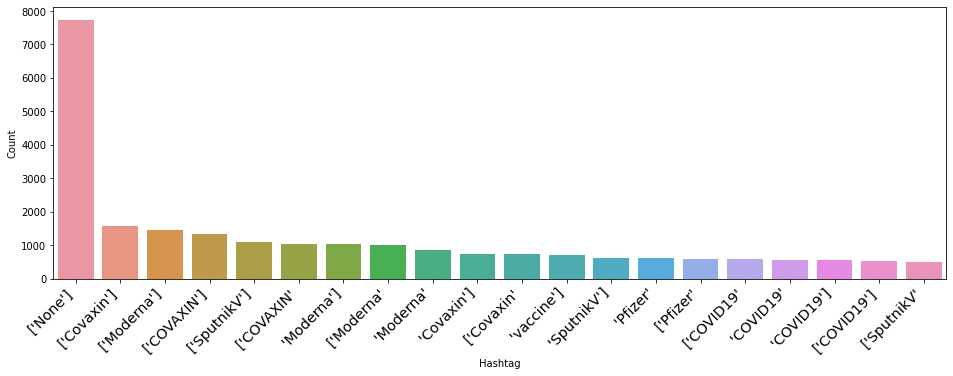

In [ ]:
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})

# selecting top 20 most frequent hashtags     
e = e.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.show()

#### Positive Tweets

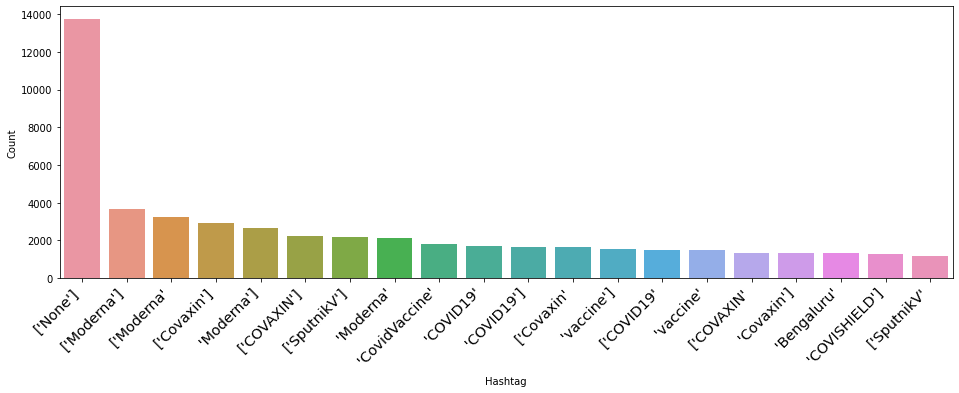

In [ ]:
c = nltk.FreqDist(HT_positive)
f = pd.DataFrame({'Hashtag': list(c.keys()), 'Count': list(c.values())})

# selecting top 20 most frequent hashtags     
f = f.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=f, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.show()

#### Neutral Tweets

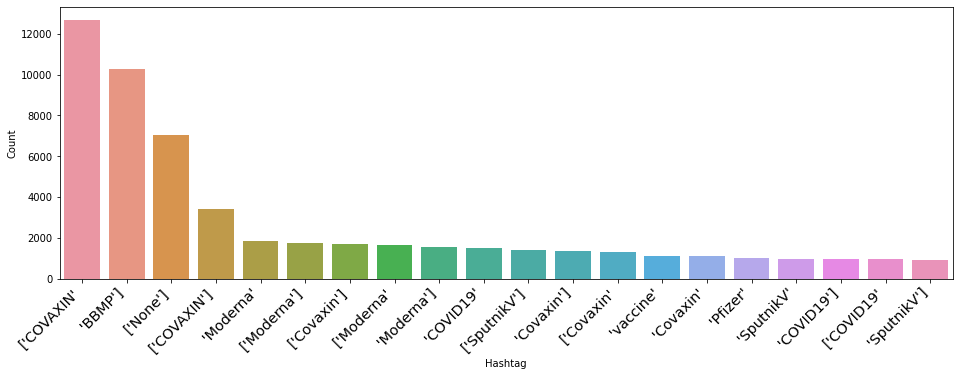

In [ ]:
a = nltk.FreqDist(HT_neutral)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.show()

## Sentiment Analysis

## Sentiment analysis as bar chart

In [ ]:
def plotSentiment(df, feature, title):
    counts = df[feature].value_counts()
    percent = counts/sum(counts)

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

    counts.plot(kind='bar', ax=ax1, color='green')
    percent.plot(kind='bar', ax=ax2, color='blue')
    ax1.set_ylabel(f'Counts : {title} sentiments', size=12)
    ax2.set_ylabel(f'Percentage : {title} sentiments', size=12)
    plt.suptitle(f"Sentiment analysis: {title}")
    plt.tight_layout()
    plt.show()

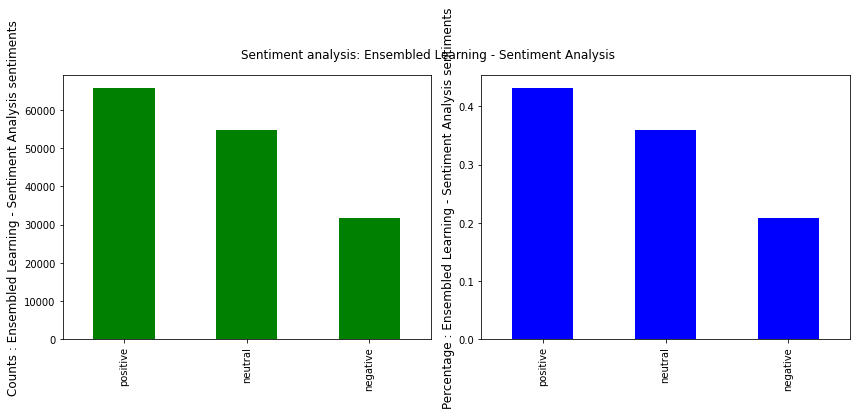

In [ ]:
plotSentiment(vax_tweets, 'sentiment', 'Ensembled Learning - Sentiment Analysis')

## Time series analysis of sentiment

In [ ]:
timeline_sentiment = vax_tweets.groupby(['date', 'sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()
fig = px.line(timeline_sentiment, x='date', y='tweets', color='sentiment', category_orders={'sentiment': ['neutral', 'negative', 'positive']},
             title='Timeline showing sentiment of tweets about COVID-19 vaccines')

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

fig.show()

In [ ]:
spike = vax_tweets[vax_tweets['date'].astype(str)=='2021-07-24']
spike['user_location'].value_counts(ascending=False).head(10)

Bengaluru, India                  165
Bouches-du-Rhône, Provence-Alp     42
India                              22
New Delhi, India                   10
Sri Lanka                           9
Mumbai, India                       7
United States                       6
Dhaka, Bangladesh                   5
Pakistan                            4
Canada                              4
Name: user_location, dtype: int64

In [ ]:
spike = spike.sort_values('user_location', ascending=False)

In [ ]:
all_vax = ['covaxin', 'sinopharm', 'sinovac', 'moderna', 'pfizer', 'biontech', 'oxford', 'astrazeneca', 'sputnik']

# Function to filter the data to a single vaccine and plot the timeline
# Note: a lot of the tweets seem to contain hashtags for multiple vaccines even though they are specifically referring to one vaccine - not very helpful!
def filtered_timeline(df, vax, title):
    df = df.dropna()
    title_str = 'Timeline showing sentiment of tweets about the '+title+' vaccine'
    df_filt = pd.DataFrame()
    for o in vax:
        df_filt = df_filt.append(df[df['text'].str.lower().str.contains(o)])
    other_vax = list(set(all_vax)-set(vax))
    for o in other_vax:
        df_filt = df_filt[~df_filt['text'].str.lower().str.contains(o)]
    df_filt = df_filt.drop_duplicates()
    timeline = df_filt.groupby(['date', 'sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index()
    print(timeline)
    fig = px.line(timeline, x='date', y='tweets', color='sentiment', category_orders={'sentiment': ['neutral', 'negative', 'positive']},title=title_str)
    
    fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))
    
    fig.show()
    return df_filt

covaxin = filtered_timeline(vax_tweets, ['covaxin'], title='Covaxin')

TypeError: ignored

In [ ]:
def date_filter(df, date):
    return df[df['date'].astype(str)==date].sort_values('user_followers', ascending=False)[['date' ,'text']]

def date_printer(df, dates, num=10): 
    for date in dates:
        display(date_filter(df, date).head(num))

date_printer(covaxin, ['2021-05-01', '2021-07-03'])

NameError: ignored

## Timeline displaying varying sentiments on COVID-19 vaccine suppliers.

In [ ]:
sinovac = filtered_timeline(vax_tweets, ['sinovac'], title='Sinovac')
moderna = filtered_timeline(vax_tweets, ['moderna'], title='Moderna')
sputnikv = filtered_timeline(vax_tweets, ['sputnik'], title='Sputnik V')
sinopharm = filtered_timeline(vax_tweets, ['sinopharm'], title='Sinopharm')
pfizer = filtered_timeline(vax_tweets, ['pfizer', 'biontech'], title='Pfizer/BioNTech')
oxford = filtered_timeline(vax_tweets, ['oxford', 'astrazeneca'], title='Oxford/AstraZeneca')

## Vaccine supplier sentiments reflected by Z-scored.

In [ ]:
# Get z scores of sentiment for each vaccine
vax_names = {'Covaxin': covaxin, 'Sinovac': sinovac, 'Sinopharm': sinopharm,
            'Moderna': moderna, 'Oxford/AstraZeneca': oxford, 'PfizerBioNTech': pfizer}
sentiment_zscores = pd.DataFrame()
for k, v in vax_names.items():
    senti = v['sentiment'].value_counts(normalize=True)
    senti['vaccine'] = k
    sentiment_zscores = sentiment_zscores.append(senti)
for col in ['negative', 'neutral', 'positive']:
    sentiment_zscores[col+'_zscore'] = (sentiment_zscores[col] - sentiment_zscores[col].mean())/sentiment_zscores[col].std(ddof=0)
sentiment_zscores.set_index('vaccine', inplace=True)

# Plot the results
ax = sentiment_zscores.sort_values('negative_zscore')['negative_zscore'].plot.barh(title='Z scores of negative sentiment')
ax.set_ylabel('Vaccine')
ax.set_xlabel('Z score');

NameError: ignored

## Time series analysis of Emotions

In [ ]:
emotion_timeline = vax_tweets.groupby(['date', 'emotions']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()
fig = px.line(emotion_timeline, x='date', y='tweets', color='emotions')
fig.show()

## Theme analysis overtime

In [ ]:
timeline_themes = vax_tweets.groupby(['date', 'tweet_topics']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()
fig = px.line(timeline_themes, x='date', y='tweets', color='tweet_topics')
fig.show()

## Analysis of tweets regarding vaccination, including both those that are anti-vaccine and those that are pro-vaccine.

In [ ]:
timeline_anti_pro = vax_tweets.groupby(['date', 'tweet_classification']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()
fig = px.line(timeline_anti_pro, x='date', y='tweets', color='tweet_classification')
fig.show()

# Hastags

In [ ]:
a= {'Vaccine' : 35.75, 'COVID-19': 44.32, "Moderna": 20.21, "Covaxin" : 18.65, "SputnikV" : 13, "Pfizer" : 11, "Sinovac" : 10, "AstraZeneca" : 7, 'Sinopharm' : 5}

In [ ]:
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Percentage (%)')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.show()

# Topic Modeling

In [38]:
!pip install bertopic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
from bertopic import BERTopic

In [ ]:
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(vax_tweets['text'])

In [ ]:
topic_model.visualize_barchart()

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_hierarchy()

In [ ]:
topics_over_time = topic_model.topics_over_time(vax_tweets['text'], vax_tweets['date'])

In [ ]:
topic_model.visualize_topics_over_time(topics_over_time, topics=[0, 1, 2, 3, 4, 5, 6,7])